In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Import required packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from project_ENGIE import Project_Engie
from operational_analysis.methods import electrical_losses

In the call below, make sure the appropriate path to the CSV input files is specfied. In this example, the CSV files are located directly in the 'examples/operational_AEP_analysis/data' folder.

In [3]:
# Load plant object
project = Project_Engie('./data/la_haute_borne/')

In [4]:
# Prepare data
project.prepare()

INFO:project_ENGIE:Loading SCADA data
INFO:operational_analysis.types.timeseries_table:Loading name:la-haute-borne-data-2014-2015
INFO:project_ENGIE:SCADA data loaded
INFO:project_ENGIE:Timestamp QC and conversion to UTC
INFO:project_ENGIE:Correcting for out of range of temperature variables
INFO:project_ENGIE:Flagging unresponsive sensors
INFO:project_ENGIE:Converting field names to IEC 61400-25 standard
INFO:operational_analysis.types.timeseries_table:Loading name:plant_data
INFO:operational_analysis.types.timeseries_table:Loading name:plant_data
INFO:operational_analysis.types.timeseries_table:Loading name:merra2_la_haute_borne
INFO:operational_analysis.types.timeseries_table:Loading name:era5_wind_la_haute_borne


In [5]:
el = electrical_losses.ElectricalLosses(project)

INFO:operational_analysis.methods.electrical_losses:Initializing Electrical Losses Object


In [6]:
el.run()

INFO:operational_analysis.methods.electrical_losses:Processing SCADA data
INFO:operational_analysis.methods.electrical_losses:Processing meter data
INFO:operational_analysis.methods.electrical_losses:Calculating electrical losses


#### Examine results

In [11]:
# Long-term annual TIE for whole plant
print('Long-term electrical losses are %s percent' % np.round(el._electrical_losses*100,1))
#el._electrical_losses

Long-term electrical losses are 2.2 percent


Text(0, 0.5, 'Electrical Losses (%)')

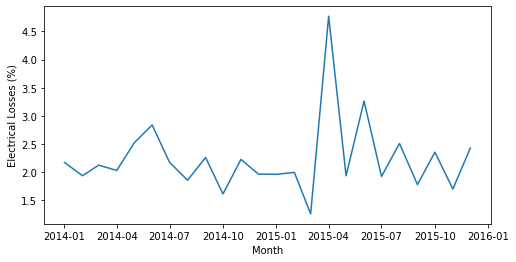

In [23]:
# Let's plot electrical losses by month
plt.figure(figsize = (8,4))
monthly_merge = el._merge_df.resample('MS').sum()
plt.plot((monthly_merge['corrected_energy'] - monthly_merge['energy_kwh']) / monthly_merge['corrected_energy'] * 100)
plt.xlabel('Month')
plt.ylabel('Electrical Losses (%)')